<a href="https://colab.research.google.com/github/Culeshovi/deep-learning/blob/master/miceliver.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
from googleapiclient.discovery import build
import io, os
from googleapiclient.http import MediaIoBaseDownload
from google.colab import auth

auth.authenticate_user()

drive_service = build('drive', 'v3')
results = drive_service.files().list(


q="name = 'liver.zip'", fields="files(id)").execute()
kaggle_api_key = results.get('files', [])

filename = "/content/liver.zip"
os.makedirs(os.path.dirname(filename), exist_ok=True)

request = drive_service.files().get_media(fileId=kaggle_api_key[0]['id'])
fh = io.FileIO(filename, 'wb')
downloader = MediaIoBaseDownload(fh, request)
done = False
while done is False:
    status, done = downloader.next_chunk()
    print("Download %d%%." % int(status.progress() * 100))
os.chmod(filename, 600)

Download 100%.


In [0]:
!unzip liver.zip

Archive:  liver.zip
   creating: liver/
   creating: liver/Damaged/
 extracting: liver/Damaged/1.jpg     
 extracting: liver/Damaged/2.jpg     
 extracting: liver/Damaged/3.jpg     
 extracting: liver/Damaged/4.jpg     
 extracting: liver/Damaged/5.jpg     
 extracting: liver/Damaged/6.jpg     
 extracting: liver/Damaged/8.jpg     
 extracting: liver/Damaged/9.jpg     
   creating: liver/Normal/
 extracting: liver/Normal/1.jpg      
 extracting: liver/Normal/2-1.jpg    
 extracting: liver/Normal/2.jpg      
 extracting: liver/Normal/5.jpg      
 extracting: liver/Normal/7.jpg      
  inflating: liver/test.py           


In [0]:
import os
os.chdir('liver')
import numpy as np
import pandas as pd
import cv2
from glob import glob
import matplotlib.pyplot as plt
%matplotlib inline
from matplotlib import style
#style.use('ggplot')
style.use('seaborn-darkgrid')

import keras.backend as K

from keras.models import Sequential,Model


from keras.layers import MaxPooling2D,Reshape,Cropping2D,Dense, Dropout, Flatten, Input, Conv2D, multiply, LocallyConnected2D,BatchNormalization,UpSampling2D,Conv2DTranspose
from keras.utils import np_utils
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img



Using TensorFlow backend.


In [0]:
def cropIM(im,size=[320,240]):
    w,h=im.size
    w_max,h_max = w-size[0],h-size[1]
    l,d=np.random.randint(0,w_max+1),np.random.randint(0,h_max+1)
    return im.crop(box=(l,d,l+size[0],d+size[1]))

In [0]:
def cropimages(im):
  M=im.shape[0]/2
  N=im.shape[1]/2
  tiles=[im[x:x+M,y:y+N] for x in range(0,im.shape[0],M) for y in range(0,im.shape[1],N)]
  return tiles

In [0]:
def crop(im,height,width):
    # im = Image.open(infile)
    lis=[]
    imgwidth, imgheight = im.size
    for i in range(int(imgheight/height)):
        for j in range(int(imgwidth/width)):
            # print (i,j)
            box = (j*width, i*height, (j+1)*width, (i+1)*height)
            lis.append(im.crop(box))
    return lis

In [0]:
def histo_equalized(imgs):
    assert (len(imgs.shape)==4)  #4D arrays
    assert (imgs.shape[1]==1)  #check the channel is 1
    imgs_equalized = np.empty(imgs.shape)
    for i in range(imgs.shape[0]):
        imgs_equalized[i,0] = cv2.equalizeHist(np.array(imgs[i,0], dtype = np.uint8))
    return imgs_equalized

In [0]:
def clahe_equalized(imgs):
    assert (len(imgs.shape)==4)  #4D arrays
    assert (imgs.shape[1]==1)  #check the channel is 1
    #create a CLAHE object (Arguments are optional).
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
    imgs_equalized = np.empty(imgs.shape)
    for i in range(imgs.shape[0]):
        imgs_equalized[i,0] = clahe.apply(np.array(imgs[i,0], dtype = np.uint8))
    return imgs_equalized


In [0]:
def dataset_normalized(imgs):
    assert (len(imgs.shape)==4)  #4D arrays
    assert (imgs.shape[1]==1)  #check the channel is 1
    imgs_normalized = np.empty(imgs.shape)
    imgs_std = np.std(imgs)
    imgs_mean = np.mean(imgs)
    imgs_normalized = (imgs-imgs_mean)/imgs_std
    for i in range(imgs.shape[0]):
        imgs_normalized[i] = ((imgs_normalized[i] - np.min(imgs_normalized[i])) / (np.max(imgs_normalized[i])-np.min(imgs_normalized[i])))*255
    return imgs_normalized


def adjust_gamma(imgs, gamma=1.0):
    assert (len(imgs.shape)==4)  #4D arrays
    assert (imgs.shape[1]==1)  #check the channel is 1
    # build a lookup table mapping the pixel values [0, 255] to
    # their adjusted gamma values
    invGamma = 1.0 / gamma
    table = np.array([((i / 255.0) ** invGamma) * 255 for i in np.arange(0, 256)]).astype("uint8")
    # apply gamma correction using the lookup table
    new_imgs = np.empty(imgs.shape)
    for i in range(imgs.shape[0]):
        new_imgs[i,0] = cv2.LUT(np.array(imgs[i,0], dtype = np.uint8), table)
    return new_imgs

In [0]:
def rgb2gray(rgb):
    assert (len(rgb.shape)==4)  #4D arrays
    assert (rgb.shape[1]==3)
    bn_imgs = rgb[:,0,:,:]*0.299 + rgb[:,1,:,:]*0.587 + rgb[:,2,:,:]*0.114
    bn_imgs = np.reshape(bn_imgs,(rgb.shape[0],1,rgb.shape[2],rgb.shape[3]))
    return bn_imgs


In [0]:
def my_PreProc(data):
    assert(len(data.shape)==4)
    assert (data.shape[1]==3)  #Use the original images
    #black-white conversion
    train_imgs = rgb2gray(data)
    #my preprocessing:
    train_imgs = dataset_normalized(train_imgs)
    train_imgs = clahe_equalized(train_imgs)
    train_imgs = adjust_gamma(train_imgs, 1.2)
    train_imgs = train_imgs/255.  #reduce to 0-1 range
    return train_imgs

In [0]:
"""from PIL import Image
data1=os.listdir('Normal')
data2=os.listdir('Damaged')

DATA=[]
LABEL=[]

for i in range(len(data1)):
  im=Image.open('Normal/'+data1[i])
  imgwidth, imgheight = im.size
  height = imgheight/2
  width = imgwidth/2
  #im=np.ndarray(im)/255
  #print (im.size)
  im=crop(im,height,width)
  for j in im:
    j=np.array(j)/255
    DATA.append(j)
    LABEL.append(0)

for i in range(len(data2)):
  im=Image.open('Damaged/'+data2[i])
  imgwidth, imgheight = im.size
  height = imgheight/2
  width = imgwidth/2
  #im=np.ndarray(im)/255
  #print (im.size)
  im=crop(im,height,width)
  for j in im:
    j=np.array(j)/255
    DATA.append(j)
    LABEL.append(1)


"""

"from PIL import Image\ndata1=os.listdir('Normal')\ndata2=os.listdir('Damaged')\n\nDATA=[]\nLABEL=[]\n\nfor i in range(len(data1)):\n  im=Image.open('Normal/'+data1[i])\n  imgwidth, imgheight = im.size\n  height = imgheight/2\n  width = imgwidth/2\n  #im=np.ndarray(im)/255\n  #print (im.size)\n  im=crop(im,height,width)\n  for j in im:\n    j=np.array(j)/255\n    DATA.append(j)\n    LABEL.append(0)\n\nfor i in range(len(data2)):\n  im=Image.open('Damaged/'+data2[i])\n  imgwidth, imgheight = im.size\n  height = imgheight/2\n  width = imgwidth/2\n  #im=np.ndarray(im)/255\n  #print (im.size)\n  im=crop(im,height,width)\n  for j in im:\n    j=np.array(j)/255\n    DATA.append(j)\n    LABEL.append(1)\n\n\n"

In [0]:
from PIL import Image
data1=os.listdir('Normal')
data2=os.listdir('Damaged')

DATA=[]
LABEL=[]

for i in range(1,len(data1)):
  im=Image.open('Normal/'+data1[i])
  #imgwidth, imgheight = im.size
  #height = imgheight/2
  #width = imgwidth/2
  #im=np.ndarray(im)/255
  #print (im.size)
  #im=crop(im,height,width)
  for j in range(1000):
    res=cropIM(im)
    res=np.array(res)
    DATA.append(res)
    LABEL.append(0)

for i in range(1,len(data2)):
  im=Image.open('Damaged/'+data2[i])
  imgwidth, imgheight = im.size
  height = imgheight/2
  width = imgwidth/2
  #im=np.ndarray(im)/255
  #print (im.size)
  for j in range(500):
    res=cropIM(im)
    res=np.array(res)
    DATA.append(res)
    LABEL.append(1)




In [0]:
print (np.array(DATA).shape,np.array(LABEL).shape)

(7500, 240, 320, 3) (7500,)


In [0]:
DATAt=[]
LABELt=[]
im=Image.open('Normal/'+data1[0])
print (np.array(im).shape)
  #imgwidth, imgheight = im.size
  #height = imgheight/2
  #width = imgwidth/2
  #im=np.ndarray(im)/255
  #print (im.size)
  #im=crop(im,height,width)
for j in range(375):
  res=cropIM(im)
  res=np.array(res)
  DATAt.append(res)
  LABELt.append(0)

im=Image.open('Damaged/'+data2[0])
  #imgwidth, imgheight = im.size
  #height = imgheight/2
  #width = imgwidth/2
  #im=np.ndarray(im)/255
  #print (im.size)
  #im=crop(im,height,width)
for j in range(375):
  res=cropIM(im)
  res=np.array(res)
  DATAt.append(res)
  LABELt.append(1)






(1920, 2560, 3)


In [0]:
DATA=np.array(DATA)
LABEL=np.array(LABEL)
DATAt=np.array(DATAt)
LABELt=np.array(LABELt)




In [0]:
DATA=np.rollaxis(DATA,3, 1) 
DATA=my_PreProc(DATA)
DATA=np.moveaxis(DATA,1, 3)

DATAt=np.rollaxis(DATAt,3, 1) 
DATAt=my_PreProc(DATAt)
DATAt=np.moveaxis(DATAt,1, 3)



In [0]:
datagen = ImageDataGenerator(
    rotation_range=20,
    vertical_flip=True,
    horizontal_flip=True)
datagen.fit(DATA)

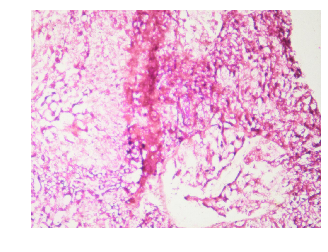

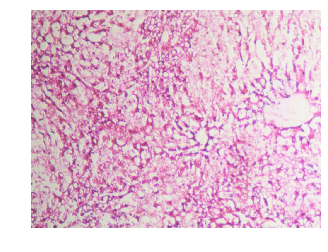

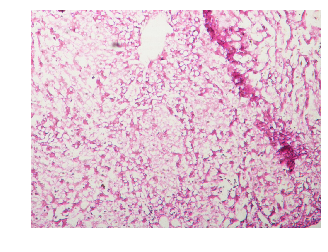

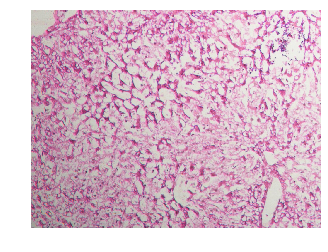

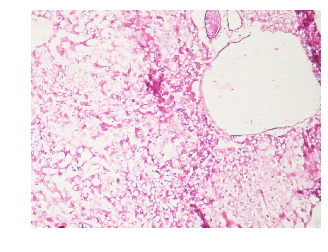

In [0]:
"""
tick=5
while (tick>0):
  fig, (ax1) = plt.subplots(1, 1)
  ax1.imshow(DATA[tick],cmap='bone')
  #ax2.imshow(np.squeeze(LABEL[tick],-1),cmap='bone')
  ax1.axis('off')
  #ax2.axis('off')
  tick=tick-1
  """

In [0]:
in_lay=Input((240,320,1))


l1=Conv2D(32, kernel_size = (3,3),strides=(1,1), padding = 'same',activation = 'relu')(in_lay)
l1=MaxPooling2D(pool_size=(2, 2), strides=2)(l1)
l1=BatchNormalization()(l1)



l1=Conv2D(64, kernel_size = (3,3),strides=(1,1), padding = 'same',activation = 'relu')(l1)
l1=MaxPooling2D(pool_size=(2, 2), strides=2)(l1)
l1=BatchNormalization()(l1)

l1=Conv2D(128, kernel_size = (3,3),strides=(1,1), padding = 'same',activation = 'relu')(l1)
l1=MaxPooling2D(pool_size=(2, 2), strides=2)(l1)
l1=BatchNormalization()(l1)




l1=Conv2D(256, kernel_size = (3,3),strides=(1,1), padding = 'same',activation = 'relu')(l1)
l1=MaxPooling2D(pool_size=(2, 2), strides=2)(l1)
l1=BatchNormalization()(l1)

l1=Conv2D(256, kernel_size = (3,3),strides=(1,1), padding = 'same',activation = 'relu')(l1)
l1=MaxPooling2D(pool_size=(2, 2), strides=2)(l1)
l1=BatchNormalization()(l1)


l1=Conv2D(512, kernel_size = (3,3),strides=(1,1), padding = 'same',activation = 'relu')(l1)
l1=MaxPooling2D(pool_size=(2, 2), strides=2)(l1)
l1=BatchNormalization()(l1)

l1=Conv2D(512, kernel_size = (3,3),strides=(1,1), padding = 'same',activation = 'relu')(l1)
l1=MaxPooling2D(pool_size=(2, 2), strides=2)(l1)
l1=BatchNormalization()(l1)


l1=Flatten()(l1)#
#l1=Dense(units=2048,activation='relu')(l1)
l1=Dense(units=512,activation='relu')(l1)
Out=Dense(units=1,activation='sigmoid')(l1)




model=Model(inputs = [in_lay], outputs = [Out])
model.compile(optimizer = 'adam', loss = 'binary_crossentropy',
                           metrics=['accuracy'])
model.summary()






















Instructions for updating:
Colocations handled automatically by placer.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 240, 320, 1)       0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 240, 320, 32)      320       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 120, 160, 32)      0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 120, 160, 32)      128       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 120, 160, 64)      18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 60, 80, 64)        0         
_________________________________________________________________
batc

In [0]:
from keras.callbacks import ModelCheckpoint, LearningRateScheduler, EarlyStopping, ReduceLROnPlateau
weight_path="{}_weights.best.hdf5".format('mice_result')

checkpoint = ModelCheckpoint(weight_path, monitor='val_loss', verbose=1, 
                             save_best_only=True, mode='min', save_weights_only = True)


reduceLROnPlat = ReduceLROnPlateau(monitor='val_loss', factor=0.8, patience=5, verbose=1, mode='auto', min_delta=0.0001, cooldown=5, min_lr=0.0000001)
early = EarlyStopping(monitor="val_loss", 
                      mode="min", 
                      patience=150)
callbacks_list = [checkpoint, early, reduceLROnPlat,]
model_json = model.to_json()
with open("model.json", "w") as json_file:
    json_file.write(model_json)

In [0]:
from google.colab import files
files.download('model.json')

In [0]:
#hist=model.fit(DATA,LABEL,batch_size=150,validation_data=(DATAt,LABELt),epochs=200,shuffle=True)
hist=model.fit_generator(datagen.flow(DATA,LABEL,batch_size=150),validation_data=(DATAt,LABELt),steps_per_epoch=len(DATA)/150,callbacks=callbacks_list,use_multiprocessing=True,epochs=300,shuffle=True)

Instructions for updating:
Use tf.cast instead.
Epoch 1/300
50/50 [==============================] - 68s 1s/step - loss: 0.4259 - acc: 0.8599 - val_loss: 7.9712 - val_acc: 0.5000

Epoch 00001: val_loss improved from inf to 7.97119, saving model to mice_result_weights.best.hdf5
Epoch 2/300
50/50 [==============================] - 61s 1s/step - loss: 0.0517 - acc: 0.9816 - val_loss: 7.8960 - val_acc: 0.5000

Epoch 00002: val_loss improved from 7.97119 to 7.89597, saving model to mice_result_weights.best.hdf5
Epoch 3/300
50/50 [==============================] - 62s 1s/step - loss: 0.0425 - acc: 0.9844 - val_loss: 2.8040 - val_acc: 0.5093

Epoch 00003: val_loss improved from 7.89597 to 2.80401, saving model to mice_result_weights.best.hdf5
Epoch 4/300
50/50 [==============================] - 62s 1s/step - loss: 0.0325 - acc: 0.9876 - val_loss: 7.9542 - val_acc: 0.5000

Epoch 00004: val_loss did not improve from 2.80401
Epoch 5/300
50/50 [==============================] - 62s 1s/step - loss

Process ForkPoolWorker-1:
Traceback (most recent call last):
  File "/usr/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
  File "/usr/lib/python3.6/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/usr/lib/python3.6/multiprocessing/pool.py", line 119, in worker
    result = (True, func(*args, **kwds))
  File "/usr/local/lib/python3.6/dist-packages/keras/utils/data_utils.py", line 626, in next_sample
    return six.next(_SHARED_SEQUENCES[uid])
  File "/usr/local/lib/python3.6/dist-packages/keras_preprocessing/image/iterator.py", line 100, in __next__
    return self.next(*args, **kwargs)
  File "/usr/local/lib/python3.6/dist-packages/keras_preprocessing/image/iterator.py", line 112, in next
    return self._get_batches_of_transformed_samples(index_array)
  File "/usr/local/lib/python3.6/dist-packages/keras_preprocessing/image/numpy_array_iterator.py", line 151, in _get_batches_of_transformed_samples
   

KeyboardInterrupt: ignored

In [0]:
from google.colab import files
files.download('mice_result_weights.best.hdf5')


KeyboardInterrupt: ignored

In [0]:
from PIL import Image
DATA1=[]
LABEL1=[]
REAL=[]


for i in range(len(data)):
  im=Image.open('training/images/'+data[i])
  res=im.resize((512, 512), Image.ANTIALIAS)
  REAL.append(np.array(res))
  DATA1.append(np.array(res))
DATA1=np.stack(DATA1)
DATA1=np.rollaxis(DATA1,3, 1) 
DATA1=my_PreProc(DATA1)
DATA1=np.moveaxis(DATA1,1, 3)

print (DATA1.shape)

(20, 512, 512, 1)


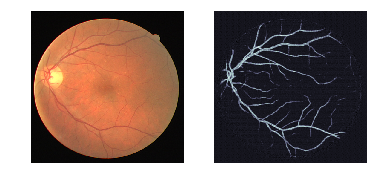

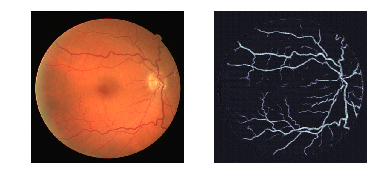

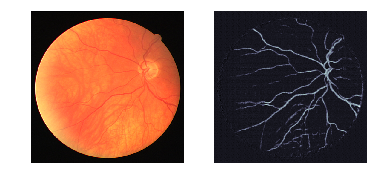

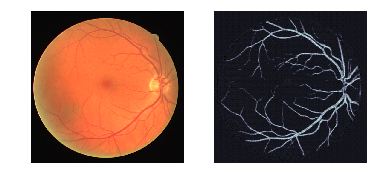

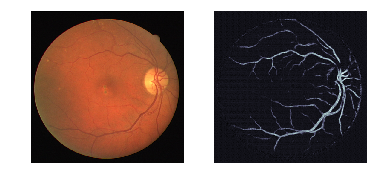

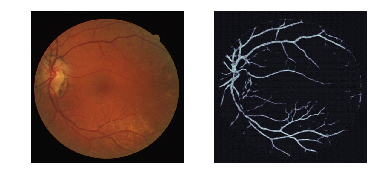

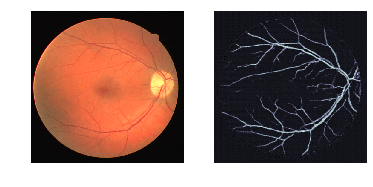

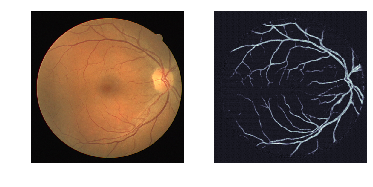

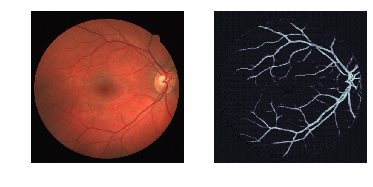

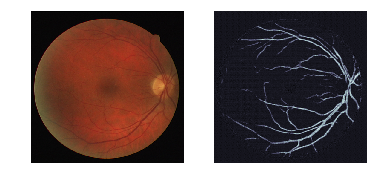

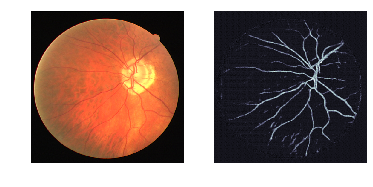

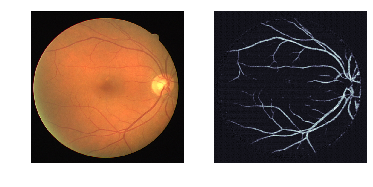

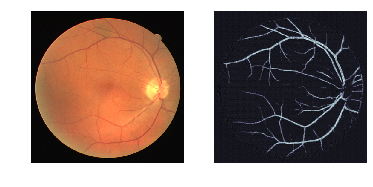

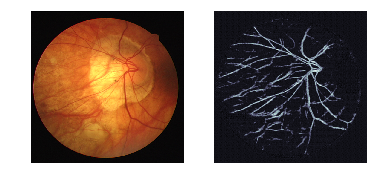

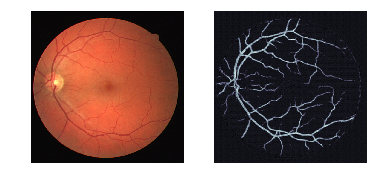

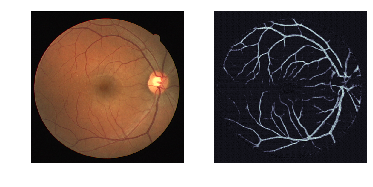

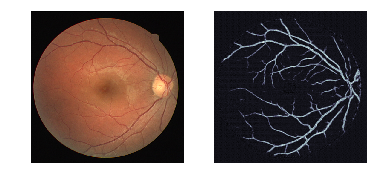

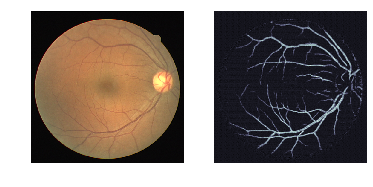

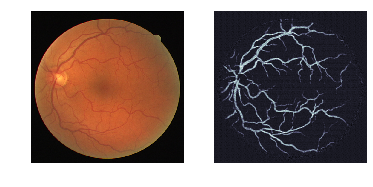

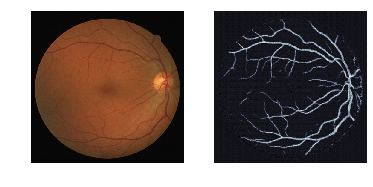

In [0]:
for i in range(len(data)):
  fig, (ax1, ax2) = plt.subplots(1,2)
  
  ax1.imshow(REAL[i],cmap='bone')
  pred=model.predict(np.expand_dims(DATA1[i],axis=0))
  #im3=Image.open('training/mask/'+str(21+i)+'_training_mask.gif')
  pred=np.squeeze(pred,axis=-1)
  pred=np.squeeze(pred,axis=0)
  #im3=im3.resize((512, 512), Image.ANTIALIAS)
  pred=(pred*255.0)
  ax2.imshow(pred,cmap='bone')
  ax1.axis('off')
  ax2.axis('off')
  


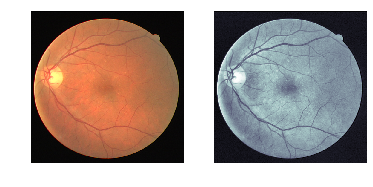

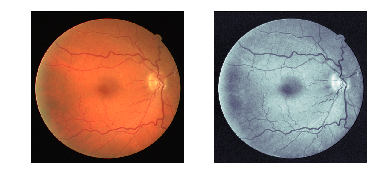

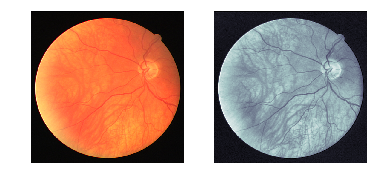

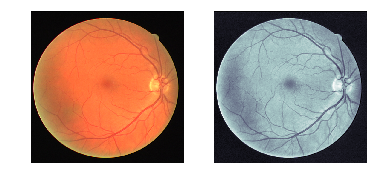

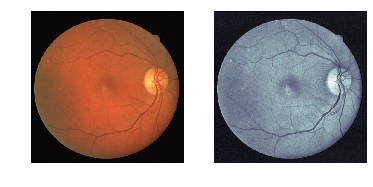

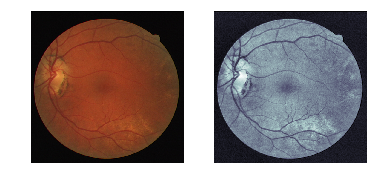

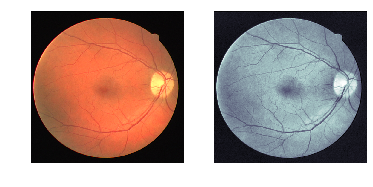

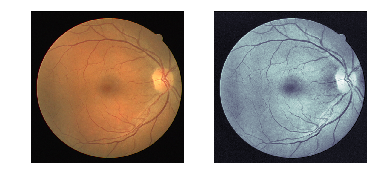

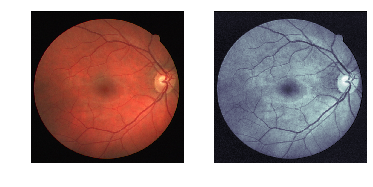

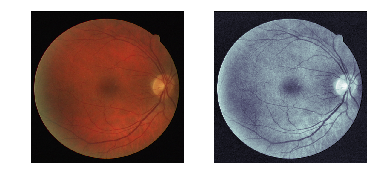

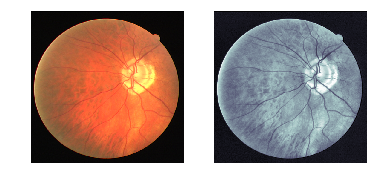

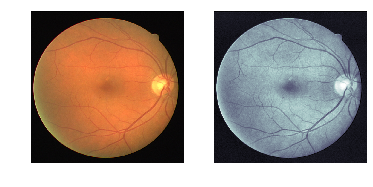

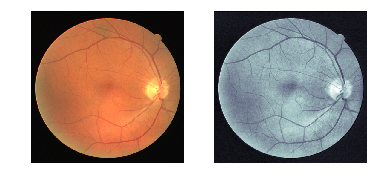

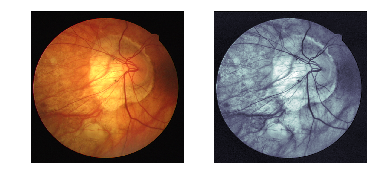

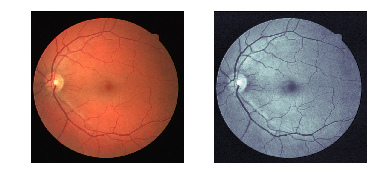

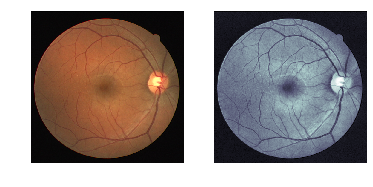

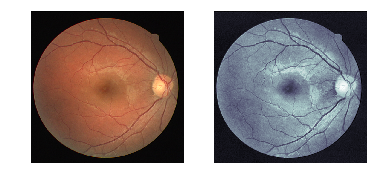

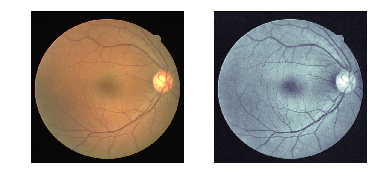

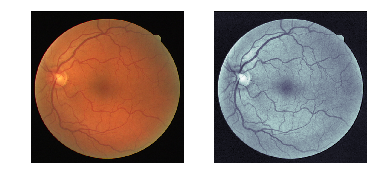

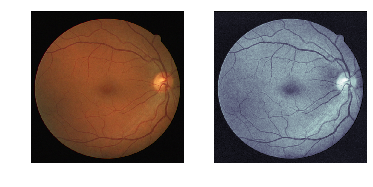

In [0]:
for i in range(len(data)):
  fig, (ax1, ax2) = plt.subplots(1,2)
  
  ax1.imshow(REAL[i],cmap='bone')
  pred=DATA1[i]
  
  #im3=Image.open('training/mask/'+str(21+i)+'_training_mask.gif')
  pred=np.squeeze(pred,axis=-1)
  #pred=np.squeeze(pred,axis=0)
  #im3=im3.resize((512, 512), Image.ANTIALIAS)
  pred=(pred*255.0)
  ax2.imshow(pred,cmap='bone')
  ax1.axis('off')
  ax2.axis('off')
  

In [0]:
from PIL import Image
DATA1=[]
LABEL1=[]
REAL=[]
data1=os.listdir('test/images/')


for i in range(len(data)):
  im=Image.open('test/images/'+data1[i])
  res=im.resize((512, 512), Image.ANTIALIAS)
  REAL.append(np.array(res))
  DATA1.append(np.array(res))
DATA1=np.stack(DATA1)
DATA1=np.rollaxis(DATA1,3, 1) 
DATA1=my_PreProc(DATA1)
DATA1=np.moveaxis(DATA1,1, 3)

print (DATA1.shape)

(20, 512, 512, 1)


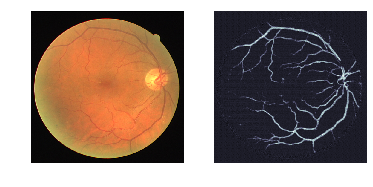

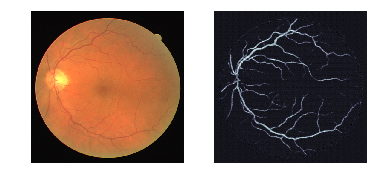

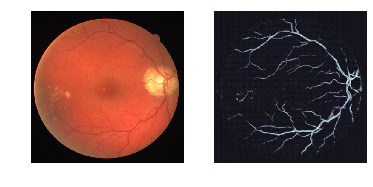

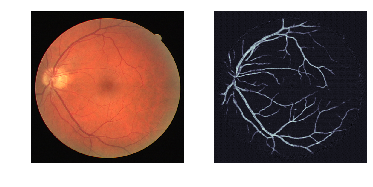

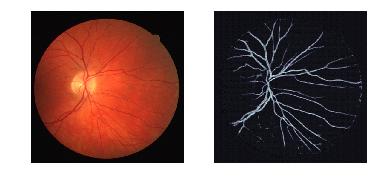

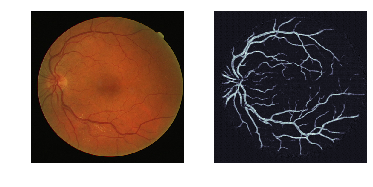

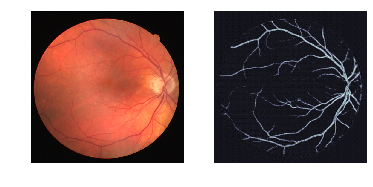

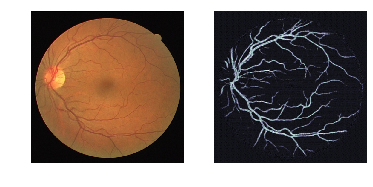

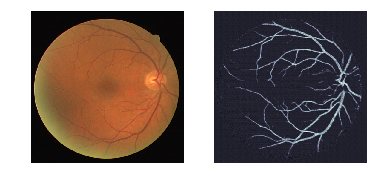

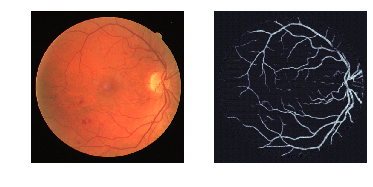

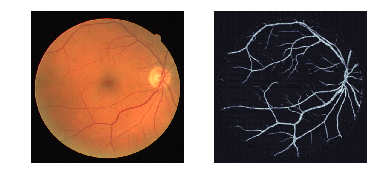

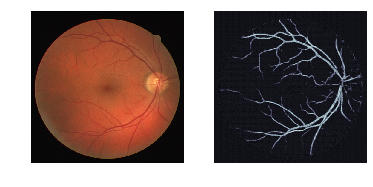

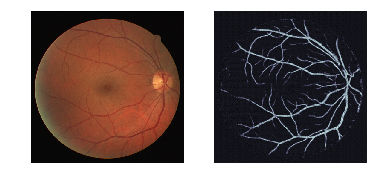

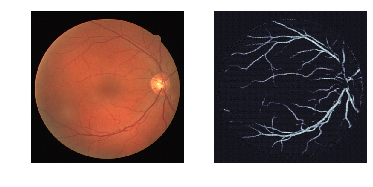

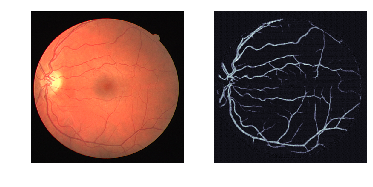

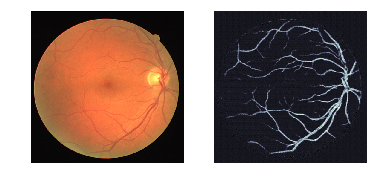

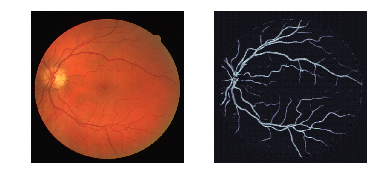

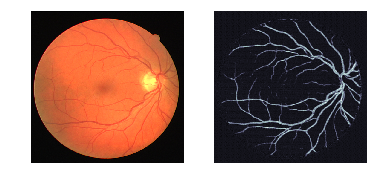

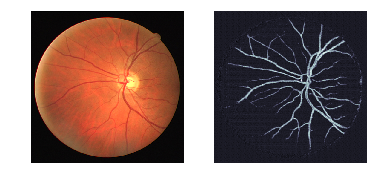

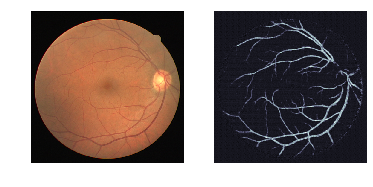

In [0]:
for i in range(len(data)):
  fig, (ax1, ax2) = plt.subplots(1,2)
  
  ax1.imshow(REAL[i],cmap='bone')
  pred=model.predict(np.expand_dims(DATA1[i],axis=0))
  #im3=Image.open('training/mask/'+str(21+i)+'_training_mask.gif')
  pred=np.squeeze(pred,axis=-1)
  pred=np.squeeze(pred,axis=0)
  #im3=im3.resize((512, 512), Image.ANTIALIAS)
  pred=(pred*255.0)
  ax2.imshow(pred,cmap='bone')
  ax1.axis('off')
  ax2.axis('off')

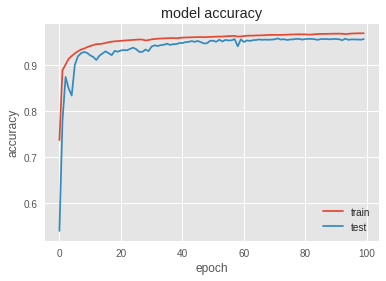

In [0]:
plt.plot(hist.history['acc'])
plt.plot(hist.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='lower right')
plt.show()

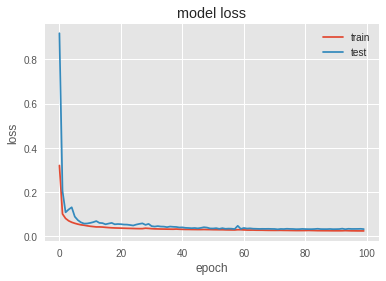

In [0]:
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right')
plt.show()